In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from tqdm import tqdm_notebook

plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

# Task 1

Solve the Poisson equation on the grid:

$$ \frac{d^2}{dr^2}U(r) = - 4 \pi r n_s(r) $$
where $n_s(r) = |\phi(r)|^2$ is the density and $U(r) = r V_H(r)$. The equation can then be written as:

$$ \frac{d^2}{dr^2}U(r) = - 4 \pi rn_s(r) $$

Space is discretized as 

$$ r_i = 0+ih \hspace{10px} i=0,...,n, \hspace{10px} h = r_{max}/n $$
which leads to 
$$ U''(r_i) = \frac{U(r_{i+1})-2U(r_i) + U(r_{i-1})}{h^2}$$

Thus our equation becomes:

$$ U(r_{i+1})-2U(r_i) + U(r_{i-1})  = - 4 \pi h^2 |\phi(r_i)|^2 r_i $$

Writing this on matrix form with the vectors for U and the density times r, $\eta$:

\begin{equation}
    U = 
    \begin{bmatrix}
        U(r_0) \\
        U(r_1) \\
        U(r_2) \\
        ... \\
    \end{bmatrix}
\end{equation}

\begin{equation}
    \eta = 
    \begin{bmatrix}
        \eta(r_0) = - 4 \pi h^2 |\phi(r_0)|^2 r_0 \\
        \eta(r_1) \\
        \eta(r_2) \\
        ... \\
    \end{bmatrix}
\end{equation}

The $U$ vectors is of length $N+2$ and $\eta$ is of length $N$, with the two endterms encoding are boundary conditions: U(0)=0, U(inf)=1. phi can be evaluated as a function. The final matrix is thus Nx(N+2) for our N ordinary equations. The first few rows are:

\begin{equation}
    A' = 
    \begin{bmatrix}
        1 & -2 & 1 & 0 & 0 & 0 \\
        0 & 1 & -2 & 1 & 0 & 0 \\
        0 & 0 & 1 & -2 & 1 & 0 \\
        ... \\
    \end{bmatrix}
\end{equation}

Note that it is not (N+2)x(N+2) since the two equations centered around our endpoints doesn't exist. We rewrite this as an NxN matrix by moving in the i=0 and i=N+1 terms. We then get the NxN matrix A':

\begin{equation}
    A = 
    \begin{bmatrix}
        -2 & 1 & 0 & 0 & 0 \\
         1 & -2 & 1 & 0 & 0 \\
         0 & 1 & -2 & 1 & 0 \\
        ... \\
    \end{bmatrix}
\end{equation}

and 

\begin{equation}
    \eta = 
    \begin{bmatrix}
        \eta(r_0) = - 4 \pi h^2 |\phi(r_0)|^2 r_0 - 0\\
        \eta(r_1) \\
        \eta(r_2) \\
        ... \\
    \end{bmatrix}
\end{equation}

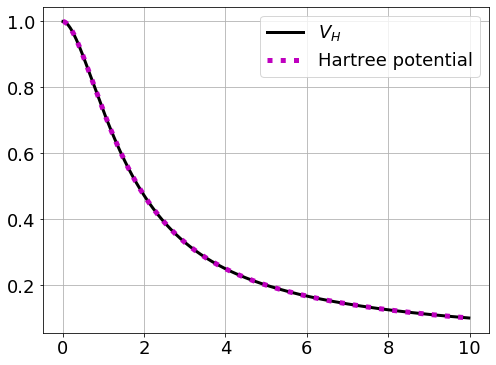

In [3]:
def phi_sq(r):
    '''Electron ground state function'''
    return 1/np.pi * np.exp(-2*r)

def Hart_pot(r):
    return 1/r - (1+1/r)*np.exp(-2*r)


N = 1000
r_inf = 10
h = r_inf/(N+2)
r = np.array([h*i for i in range(1,N+1)])
eta = -4*np.pi*r*h**2*phi_sq(r)
# Boundary conditions
eta[0] -= 0
eta[-1] -= 1

A = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if(i==j):
            A[i,j] = -2
        elif(np.abs(i-j) == 1):
            A[i,j] = 1
        else:
            A[i,j] = 0

# Solve this mf
U = np.linalg.solve(A, eta)

# Print solution
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(r, U/r, linewidth=3, c='k', label=r'$V_H$')
ax.plot(r, Hart_pot(r), c='m', linewidth=5, linestyle=':', alpha=1, label='Hartree potential')
ax.grid()
ax.legend(loc='best')

# Task 2

Implement the Schrödinger equation in a similar manner as the Poission equation above. We set V_H = 0. We discretize the derivates in f(r), which yields: 

$$ -\frac{1}{2} \frac{f(r_{i-1}) - 2f(r_{i}) + f(r_{i+1})}{h^2} - \frac{2}{r_i}f(r_i) + V_H(r_i)f(r_i) = \epsilon f(r_i) $$
$$ f(r_{i-1}) - 2f(r_{i}) + f(r_{i+1}) + \frac{4h^2}{r_i}f(r_i) - 2h^2V_H(r_i)f(r_i) = -2 h^2 \epsilon f(r_i) $$

Here we can't write the matrix on a reduced form as in task 1. We obtain the matrix equation:

$$ B'f = \lambda \tilde{f}$$

with B' being the (N)x(N+2) matrix.

\begin{equation}
    B' = 
    \begin{bmatrix}
         1 & -2 + \frac{4h^2}{r_0} - 2h^2 V_H(r_0) & 1 & 0 & 0 \\
         0 & 1 & -2 + \frac{4h^2}{r_1} - 2h^2 V_H(r_1) & 1 & 0 \\
         0 & 0 & 1 & -2 + \frac{4h^2}{r_2} - 2h^2 V_H(r_2) & 1 \\
        ... \\
    \end{bmatrix}
\end{equation}

and

\begin{equation}
    \lambda = -2 h^2 \epsilon
\end{equation}

$f(r)$ is now a vector of length $N+2$, and \tilde{f}. But since the boundary conditions are $f(0)=0$ and $f(N+1) = 0$, we can implement these boundary conditions in a similar fashion as in task A. Then we can write:

$$ f(0) \hspace{5px} -2 f(1) \hspace{5px} + f(2) = \lambda f(1) == -2 f(1) \hspace{5px} + f(2) = \lambda f(1)-0$$ 

Meaning we can write our matrix as the (NxN) matrix B:

\begin{equation}
    B = 
    \begin{bmatrix}
         -2 + \frac{4h^2}{r_0} - 2h^2 V_H(r_0) & 1 & 0 & 0 \\
         1 & -2 + \frac{4h^2}{r_1} - 2h^2 V_H(r_1) & 1 & 0 \\
         0 & 1 & -2 + \frac{4h^2}{r_2} - 2h^2 V_H(r_2) & 1 \\
        ... \\
    \end{bmatrix}
\end{equation}

and we obtain the eigenvalue equation:

$$ B \tilde{f} = \lambda \tilde{f}$$

For the case of the hydrogen atom, we set V_H = 0 and potential 1/r instead of 2/r. So we get + 2h^2/r.

In [13]:
def wavef(r):
    return 1/np.sqrt(np.pi)*np.exp(-r)

# Define matrix
B = np.zeros((N,N))

for i in tqdm_notebook(range(N)):
    for j in range(N):
        if(i==j):
            B[i,j] = 1/h**2 - 1/r[i]
        elif(np.abs(i-j) == 1):
            B[i,j] = -1/(2*h**2)
        else:
            B[i,j] = 0

# display(B)

/home/eric/miniconda3/envs/physics/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [14]:
# Calculate the eigenvalues
eigs, eigv = np.linalg.eigh(B)
idx = np.argsort(eigs)

eigs = eigs[idx]
eigv = eigv[:,idx]

-0.49998680028715026
0.0015570066622684034
0.15601487108459208
100.20180058657807


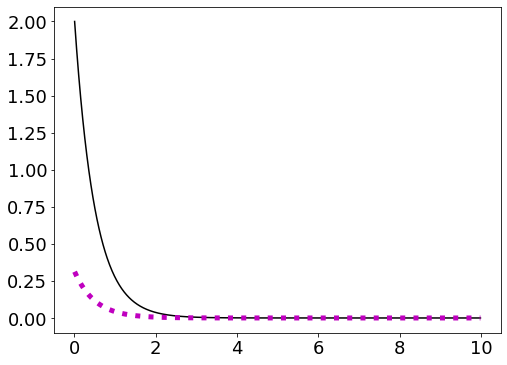

In [19]:
# fig, ax = plt.subplots(figsize=(8,6))
# ax.plot(eigs, linewidth=0, marker='*')

i_e = 0
print(eigs[i_e])

fig, ax = plt.subplots(figsize=(8,6))

wav = (eigv[:,i_e]/( np.sqrt(4*np.pi)*r) )**2
norm_wav = wav/np.trapz(wav, r)
wav_t = wavef(r)**2
print(np.trapz(wav,r))
print(np.trapz(wav_t,r))
print(np.trapz(wav_t,r)/np.trapz(wav,r))

ax.plot(r, norm_wav, c='k', label=r'$Eigenfunction$')
ax.plot(r, wav_t, c='m', linewidth=5, linestyle=':', alpha=1, label='Hydrogen 1s')
# ax.set_xlim(0,0.2)
# ax.set_ylim(0,0.5)

# Task 3

Now do the self-consistency iteration. We can reuse the matrix, but we have to update the matrix B for each iteration.

In [ ]:
def initial_trial_wave(-r):
    '''Electron ground state wavefunction - squared!'''
    return 1/np.pi * np.exp(-2*r)
    